# Probability distribution

Dowsampling strategies in some way (loss, gradient norm) construct a probability distribution over the available dataset. The aim of this notebook is to understand how the importance of the samples correlates with their temporal location. The entire probability mass of samples belonging to year X is grouped in the same bucket and then visualised.

In [ ]:
from lxml import html
import plotly.graph_objects as go
import json
import os

In [ ]:
OUTPUT_FILENAME = "probdistrcomparison.html"
LOSS_FILE = "loss.json"
GRADNORM_FILE = "gradnorm.json"
LAST_AVAILABLE_YEAR = 1989

In [ ]:
format_string_title = "<span style='font-family:  \"Hanken Grotesk\", Helvetica; color: #44546c; font-weight: 800; font-size: 45'>"
format_string_title_red = "<span style='font-family:  \"Hanken Grotesk\", Helvetica; color: #fb6a4a; font-weight: 800; font-size: 45'>"
format_string = "<span style='font-family:  \"Hanken Grotesk\", Helvetica; color: #44546c; font-weight:  300; font-size: 20'>"

## Visualization

Expected format: 2-level dict (stored as a json file). data[trigger_year][data_year] contains the total probability mass of datapoints belonging to "data_year" year when evaluated in "trigger_year" selection round. The probability should be normalized for each trigger_year, hence sum(data[trigger_year][:trigger_year + 1]) = 1 for each trigger_year 

See demo_out/probdistrcomparison.html for the interactive version and below for the static matplotlib exported

![mpl](../demo_out/probability_mass_filledTR.png)

In [ ]:
def get_chart(x_values, y_values, name, color):

    trace1_grad = go.Scatter(x=x_values, y=y_values, mode='lines', line=dict(color=color, width=5.5), name = name,  showlegend = True)
    return trace1_grad

In [ ]:
def get_slider_chart(gradnorm, loss):

    layout = go.Layout(xaxis=dict(title=f'{format_string}Time'), yaxis=dict(title=f'{format_string}Aggregated probability'), title=dict(text=f"{format_string_title}Probability distribution over time",xanchor= 'center',x=0.5, font=dict(color="#44546c", size = 35,family='helvetica' )), plot_bgcolor="#f0f0f0", paper_bgcolor='#f0f0f0')
    fig = go.Figure(layout = layout)

    # Add traces, one for each slider step
    for model_year in range(1930,LAST_AVAILABLE_YEAR):
        model_year = f"{model_year}"
        #gradnorm
        x_values = [int(key) for key in gradnorm[model_year]]
        y_values = [gradnorm[model_year][key] for key in gradnorm[model_year]]
        trace = get_chart(x_values, y_values, "gradnorm", "#FF595E")
        fig.add_trace(trace)

        #loss
        x_values = [int(key) for key in loss[model_year]]
        y_values = [loss[model_year][key] for key in loss[model_year]]
        trace = get_chart(x_values, y_values, "loss", "#E0CA3C")
        fig.add_trace(trace)


        vertical_line = go.Scatter(x=[model_year, model_year], y=[0, 1], mode='lines', line=dict(color='LightGray', dash="dot", width=4), showlegend=False)
        fig.add_trace(vertical_line)


    for i in range(len(fig.data)):
        fig.data[i].visible = False
    for i in range(4):
        fig.data[i].visible = True

    # Create and add slider
    steps = []
    for i in range(len(fig.data)//3):
        step = dict(
            method="update",
            args=[{"visible": [False] * len(fig.data)},]
        )
        step["args"][0]["visible"][3*i] = True  # Toggle i'th trace to "visible"
        step["args"][0]["visible"][3*i+1] = True
        step["args"][0]["visible"][3*i+2] = True  # Toggle i'th trace to "visible"
        steps.append(step)

    sliders = [dict(
        active=0,
        currentvalue={"prefix": "Years from beginning: "},
        pad={"t": 50},
        steps=steps,
        bgcolor="#44546c",
        tickcolor="#44546c",
        font=dict(size=8, color='#44546c', family = "helvetica")
    )]


    fig.update_layout(
        sliders=sliders
    )
    fig.update_yaxes(showline=True, linewidth=2, linecolor='#44546c', range=[0,0.2], showgrid=True, gridwidth=0.5, gridcolor='LightGray', title_font=dict(size=18, color='#44546c', family = "helvetica"), tickangle=0, tickfont=dict(family='helvetica', color='#44546c', size=14))
    fig.update_xaxes(showline=True, linewidth=2, linecolor='#44546c', range=[1930,1989], showgrid=True, gridwidth=0.5, gridcolor='LightGray', title_font=dict(size=18, color='#44546c', family = "helvetica"), tickangle=0, tickfont=dict(family='helvetica', color='#44546c', size=14))


    fig.update_layout(legend=dict(yanchor="bottom",y=1.0,xanchor="right",itemwidth=70, x=0.99, orientation = "h",font=dict(size=18, color='#44546c', family = "helvetica")))
    return fig

In [ ]:
def style_html():

    with open(OUTPUT_FILENAME, "r") as f:
        html_file = f.read()
        tree = html.fromstring(html_file)

    # Create a new root element to hold the merged HTML content
    root = html.Element("html")
    root.append(html.fromstring("""<style>
  @import url('https://fonts.googleapis.com/css2?family=Hanken+Grotesk:ital,wght@0,100;0,200;0,300;0,400;0,500;0,600;0,700;0,800;0,900;1,100;1,200;1,300;1,400;1,500;1,600;1,700;1,800;1,900&display=swap');
</style>"""))

    body = tree.xpath('//body')[0]
    body.set("style", "background-color: #44546c;")
    root.append(body)

    # Write the merged HTML to a file
    with open(OUTPUT_FILENAME, 'wb') as f:
        f.write(html.tostring(root))

In [ ]:
with open(GRADNORM_FILE, "r") as f:
    gradnorm = json.load(f)
with open(LOSS_FILE, "r") as f:
    loss = json.load(f)
fig = get_slider_chart(gradnorm, loss)
fig.write_html(OUTPUT_FILENAME, include_plotlyjs="cdn")
style_html()

# MPL version

In [8]:
sk_g = {int(key) - 1930 :gradnorm["1975"][key] for key in gradnorm["1975"]}
fl_g = {int(key) - 1930:gradnorm["1988"][key] for key in gradnorm["1988"]}

sk_l = {int(key) - 1930:loss["1975"][key] for key in loss["1975"]}
fl_l = {int(key)- 1930:loss["1988"][key] for key in loss["1988"]}

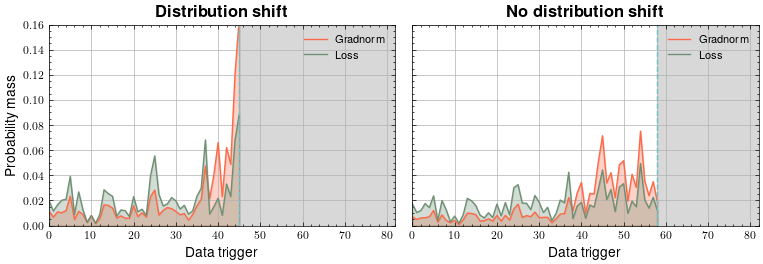

In [11]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science'])
tex_fonts = {
    "text.usetex": True,
    "font.family": "Helvetica",
    "axes.labelsize": 10,
    "font.size": 10,
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.rcParams.update(tex_fonts)
size = (7.916147779161476, 2.4462241937443947)
size = (size[0], size[1] + 0.4)
fig, axes = plt.subplots(1, 2, figsize=size, sharey="row", sharex = "row")

subplot_position = 1
axes[subplot_position].plot(fl_g.keys(), fl_g.values(), label="Gradnorm", color="#FC6A49")
axes[subplot_position].plot(fl_l.keys(), fl_l.values(), label="Loss", color="#6F9074")
axes[subplot_position].set_xlabel("Data trigger")
#axes[subplot_position].set_ylabel("Probability mass")
axes[subplot_position].fill_between(fl_g.keys(), fl_g.values(), alpha = 0.3, color = "#FC6A49")
axes[subplot_position].fill_between(fl_l.keys(), fl_l.values(), alpha = 0.3, color = "#6F9074")
title = "\\textbf{" + "No distribution shift" + "}"
axes[subplot_position].set_title(title)
axes[subplot_position].legend()

subplot_position = 0
axes[subplot_position].plot(sk_g.keys(), sk_g.values(), label="Gradnorm", color="#FC6A49")
axes[subplot_position].plot(sk_l.keys(), sk_l.values(), label="Loss", color="#6F9074")
axes[subplot_position].set_xlabel("Data trigger")
axes[subplot_position].set_ylabel("Probability mass")
axes[subplot_position].fill_between(sk_g.keys(), sk_g.values(), alpha = 0.3, color = "#FC6A49")
axes[subplot_position].fill_between(sk_l.keys(), sk_l.values(), alpha = 0.3, color = "#6F9074")
title = "\\textbf{" + "Distribution shift" + "}"
axes[subplot_position].set_title(title)
axes[subplot_position].legend()
#axes[subplot_position].yaxis.set_tick_params(labelbottom=True)

#axes[subplot_position].legend( ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.3), )
#fig.suptitle('\\textbf{Presampling Strategies}', fontsize=16)

plt.tight_layout()
#legend.get_lines()[0].set_markersize(15)
#
import numpy as np

axes[1].vlines(58, ymin=0, ymax = 0.16, color="#71C1C9", ls="--")
axes[0].vlines(45, ymin=0, ymax = 0.16, color="#71C1C9", ls="--")
axes[1].axvspan(58, 82, color='gray', alpha=0.3, label='Semi-transparent Box')
axes[0].axvspan(45, 82, color='gray', alpha=0.3, label='Semi-transparent Box')
axes[1].set_ylim(0,0.16)
axes[0].xaxis.set_ticks(np.arange(0, 82, 10))
axes[1].set_xlim(0,82)
axes[0].grid()
axes[1].grid()
plt.savefig(f"probability_mass_filledTR.pdf", format='pdf', bbox_inches='tight', transparent=True)